## Read in the data

In [1]:
import keras_tuner

# Import default libraries
import pathlib
import zipfile

# Import installed libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import tensorflow as tf

# Matplotlib darkmode
plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})

In [2]:
# Read in the level 1 data
cal_df = pd.read_pickle("data/CDA__CAT_IID_cal_data.pkl")

In [3]:
cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS
0,17.40,1.260,3,2000000.0,8.857710,2.83,43.1122,2.33,4.52835,0.00,CAT,1.664685e-17
1,12.35,0.990,0,2000000.0,8.392480,8.16,243.3150,0.66,4.80513,0.00,CAT,2.596338e-17
2,18.70,2.030,3,2000000.0,3.897020,4.00,47.3741,1.83,3.50657,0.00,CAT,2.322057e-17
3,29.10,2.058,6,2000000.0,102.422000,4.33,496.7530,0.33,23.11490,1.33,CAT,9.721189e-18
4,11.00,2.030,0,2000000.0,0.781009,1.33,42.1289,1.50,4.81273,0.00,CAT,6.710744e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
4204,9.68,2.429,7,2000000.0,10.227700,2.84,166.8690,1.83,4.71384,0.00,CAT,1.036900e-16
4205,14.78,0.990,9,2000000.0,25.061000,2.83,219.0310,1.33,5.48485,0.00,CAT,1.812785e-17
4206,14.89,0.990,4,2000000.0,7.616550,3.33,42.1660,1.17,4.70756,0.00,CAT,1.786100e-17
4207,12.29,2.506,6,2000000.0,30.925100,5.34,261.7860,1.00,5.88237,0.00,CAT,6.636472e-17


In [4]:
# In our example we'll only consider IID QI data
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

# Considering only "relevant" data: rise time and the velocity
iid_qi_cal_df = iid_qi_cal_df[["QI_TR", "PSU_VEL"]]

## Prior Calibrations

In [5]:
class DefinitionRangeError(Exception):
    """
    Class DefinitionsRangeError

    An Exception / Error class that is used to control proper calibration
    function usage. If the user uses a function with parameters that are
    out of range (outside the definition / math domain), this error can
    be raised to inform the user about the proper range.

    Attributes
    ----------
    None

    Examples

    """
    def __init__(self, trise_min=0, trise_max=np.inf, amp_min=0, amp_max=np.inf):
        """
        Method __init__

        Initializing method

        Parameters
        ----------
        trise_min : int, float, str
            Lower boundary of the rise time domain.

            Physical Quantity: microseconds (same as the calibration functions)

        trise_max : int, float, str
            Upper boundary of the rise time domain

            Physical Quantity: microseconds (same as the calibration functions)

        amp_min : int, float, str
            Lower boundary of the amplitude domain

            Physical Quantity: femtoCoulomb (same as the calibration functions)

        amp_max : int, float, str
            Upper boundary of the amplitude domain

            Physical Quantity: femtoCoulomb (same as the calibration functions)

        """


        # Set default message
        default_msg = 'Out of Range. Please set the parameters within the following range: \n\n'

        # Set message and the definition range values.
        super().__init__(default_msg \
                         + 'trise (microseconds):      (' + str(trise_min) + ', ' \
                                                          + str(trise_max) + ') \n' \
                         + 'amp (femtoCoulomb):        (' + str(amp_min)   + ', ' \
                                                          + str(amp_max)   + ') \n' \
                         + '                      log10(' + str(np.log10(amp_min)) + ', ' \
                                                          + str(np.log10(amp_max)) + ')')
        
def srama_velocity_2000(chnl, trise):
    """
    Function srama_velocity_2000

    This function computes the mean velocity and corresponding error for a
    given channel rise time. The rise time shall be given in micro seconds and
    the returned dictionary, that contains the computed values are given in
    km/s. The functions are determined by [2].

    Parameters
    ----------
    chnl : str
        Requested channel calibration function. Available options:
            'cat_qc'
            'cat_qi'
            'iid_qt'
            'iid_qi'

    trise : int, float
        Rise time value.
        Physical Quantity: microseconds

    Returns
    -------
    out : tuple
        Tuple with the mean and error velocity.

        Pysical Quantity: 'mean' : km/s
                          'err'  : km/s

    Notes:
    ------
    All three functions are defined within a certain rise time and amplitude
    domain. However, these values were not provided by [1]. Srama 2017 (priv.
    comm.) suggests to have signals with an amplitude of at least 10 fC (for
    each channel). The rise times and resulting velocities should  be handled
    with care. Extremely low velocities (< 2 - 5 km/s) and high paces
    (> 60 km/s) are mostly likely outside the definition range. Since no exact
    values are provided, no DefinitionRangeError raises.

    References
    ----------
    [2] R. Srama. Vom Cosmic-Dust-Analyzer zur Modellbeschreibung
        wissenschaftlicher Raumsonden. PhD thesis, Technische Universität
        München, 2000

    Examples
    --------
    >>> srama_velocity_2000(chnl='cat_qc', trise=10)
    (3.109411534977029, 1.5547057674885145)

    >>> srama_velocity_2000('cat_qc', trise=0.0)
    ZeroDivisionError: 0.0 cannot be raised to a negative power

    Negative rise times lead to complex number, that has no technical or
    physical meaning. 

    """
    
    # Lower the 'chnl' characters
    chnl = chnl.lower()
    
    # The calibration functions from Srama's PhD thesis are given in tens of
    # nanoseconds (10 ns). The variable, that describes the functions in his
    # thesis is named 'x' and is adapted in this function.
    x_10ns = trise * 100.0

    # Definition of each calibration function, namely of CAT QC, CAT QI, IID QT
    # and IID QI. Each function is defined as a lambda operator and is only
    # used within this function
    #
    # CAT QC: 10 x nanoseconds -> km/s
    mean_vel_cat_qc = lambda x_10ns: 5.35 + 1674270.0 * (x_10ns ** (-2.71)) \
                                     - 0.002253 * x_10ns

    # CAT QI: 10 x nanoseconds -> km/s
    mean_vel_cat_qi = lambda x_10ns: 3.535 + 18024000.0 * (x_10ns ** (-2.22)) \
                                     - 0.00127 * x_10ns

    # IID QT: 10 x nanoseconds -> km/s
    mean_vel_iid_qt = lambda x_10ns: 9.22 + 1.87 * (10.0 ** (5.0)) * (x_10ns ** (-1.26)) \
                                     - 1.45 * (10.0 ** (-3.0)) * x_10ns

    # IID QI: 10 x nanoseconds -> km/s
    mean_vel_iid_qi = lambda x_10ns: 11.3 + 3.58 * (10.0 ** (5.0)) * (x_10ns ** (-1.35)) \
                                     - 2.21 * (10.0 ** (-3.0)) * x_10ns

    # Dictionary that summarizes all parameters, functions, etc. for each
    # channel. Each sub-dictionary contains the info for each channel
    # separately.
    #
    # Structure
    # CHANNEL
    #
    #     Mean function (lambda operator)
    #     Velocity error factor
    _vel_cal = {'cat_qc': \
                    {
                        'mean_func': mean_vel_cat_qc, \
                        'err_fac':   0.50
                    }, \
                'cat_qi': \
                    {
                        'mean_func': mean_vel_cat_qi, \
                        'err_fac':   0.60
                    }, \
                'iid_qt': \
                    {
                        'mean_func': mean_vel_iid_qt, \
                        'err_fac':   0.64
                    }, \
                'iid_qi': \
                    {
                        'mean_func': mean_vel_iid_qi, \
                        'err_fac':   0.60
                    }
               }
                    
    # Compute the mean velocity in km/s, based on the rise time
    mean_vel = _vel_cal[chnl]['mean_func'](x_10ns)

    # Compute the corresponding error in km/s, based on the error factor
    err_vel = _vel_cal[chnl]['err_fac'] * mean_vel

    # Return the mean and error value
    return (mean_vel, err_vel)

def srama_velocity_2009(chnl, trise, amp=np.inf, chk=True):
    """
    Function srama_velocity_2009

    This function computes the mean velocity and corresponding error for a
    given channel rise time. The rise time shall be given in micro seconds and
    the returned dictionary, that contains the computed values are given in
    km/s. The functions are determined by [1].

    Parameters
    ----------
    chnl : str
        Requested channel calibration function. Available options:
            'cat_qc'
            'iid_qt'
            'iid_qi'

    trise : int, float
        Rise time value.
        Physical Quantity: microseconds

    amp : int, float, optional
        Amplitude of the corresponding signal. This value is used to verify
        the amplitude constrains for each calibration function. Per default
        the amplitude is to infinity.
        Physical Quantity: femtoCoulomb

    chk : bool, optional
        If true (default) the exception DefinitionsRangeError is raised, if
        the rise time(s) and / or amplitude(s) are outside the allowed
        domain.

    Returns
    -------
    out : tuple
        Tuple with the mean and error velocity.

        Pysical Quantity: 'mean' : km/s
                          'err'  : km/s

    Raises
    ------
    DefinitionRangeError
        If the given parameters are not within the valid math domain the
        DefinitionRangeError is raised.

    Notes:
    ------
    All three functions are defined within a certain rise time and
    amplitude domain. If the optional parameter chk is set to True, the
    function will check the values with the allowed range and raises an
    exception if a domain is violated. The following table lists the
    definition ranges, where trise_min and trise_max are the lower and upper
    range for trise, respectively, and amp_min is the lower boundary of the
    amplitude:
               | trise_min | trise_max || amp_min
       --------|-----------|-----------||---------
        cat_qc | 0.2       | 30.0      || 10
       --------|-----------|-----------||---------
        iid_qt | 2.5       | 80.0      || 65
       --------|-----------|-----------||---------
        iid_qi | 1.0       | 75.0      || 20

    References
    ----------
    [1] R. Srama. Cassini-Huygens and Beyond – Tools for Dust Astronomy.
        Habilitation, Fakultät für Luft- und Raumfahrttechnik und Geodäsie
        der Universität Stuttgart, 2009.

    Examples
    --------
    >>> srama_velocity_2009(chnl='cat_qc', trise=10, amp=15)
    (3.5111214630124583, 1.4746710144652324)

    Setting an out-of-range value leads to a DefinitionRangeError:

    >>> srama_velocity_2009(chnl='cat_qc', trise=0.1, amp=15)
    DefinitionRangeError: Out of Range. Please set the parameters within the
    following range:

    trise (microseconds): [0.2, 30.0]
    amp (femtoCoulomb):   [10.0, +inf]

    However one can deactivate this setting:

    >>> srama_velocity_2009('cat_qc', trise=0.1, amp=15, chk=False)
    (184.63482349254113, 77.54662586686727)

    ... that does not prevent, however, math domain errors:

    >>> srama_velocity_2009('cat_qc', trise=0.0, amp=15, chk=False)
    ZeroDivisionError: 0.0 cannot be raised to a negative power

    Negative rise times lead to complex number, that has no technical or
    physical meaning. These values are only returned, if the chk parameter
    is set to False

    """

    # Lower the 'chnl' characters
    chnl = chnl.lower()

    # Definition of each calibration function, namely of CAT QC, IID QT and
    # IID QI. Each function is defined as a lambda operator and is only used
    # within this function
    #
    # CAT QC: microseconds -> km/s
    mean_vel_cat_qc = lambda trise: 1.7 + 19.2 * (trise ** (-0.979)) - 0.0204 * trise

    # IID QT: microseconds -> km/s
    mean_vel_iid_qt = lambda trise: -240 + 361 * (trise ** (-0.117)) + 0.338 * trise

    # IID QI: microseconds -> km/s
    mean_vel_iid_qi = lambda trise: -55.3 + 253 * (trise ** (-0.423)) + 0.222 * trise

    # Dictionary that summarizes all parameters, functions, etc. for each
    # channel. Each sub-dictionary contains the info for each channel
    # separately.
    #
    # Structure
    # CHANNEL
    #
    #     Mean function (lambda operator)
    #     Velocity error factor
    #     Minimum rise time in microseconds
    #     Maximum rise time in microseconds
    #     Minimum amplitude in femtoCoulomb
    _vel_cal = {'cat_qc': \
                    {
                        'mean_func': mean_vel_cat_qc, \
                        'err_fac':   0.42, \
                        'trise_min': 0.2, \
                        'trise_max': 30.0, \
                        'amp_min':   10.0
                    }, \
                'iid_qt': \
                    {
                        'mean_func': mean_vel_iid_qt, \
                        'err_fac':   0.67, \
                        'trise_min': 2.5, \
                        'trise_max': 80.0, \
                        'amp_min':   65.0
                    }, \
                'iid_qi': \
                    {
                        'mean_func': mean_vel_iid_qi, \
                        'err_fac':   0.62, \
                        'trise_min': 1.0, \
                        'trise_max': 75.0, \
                        'amp_min':   20.0
                    }
               }

    # If the 'chk' parameter is set to True, the if clause will check if the
    # rise time and amplitude are within the allowed range.
    if chk:
        if (
                not _vel_cal[chnl]['trise_min'] < trise < _vel_cal[chnl]['trise_max'] or
                not _vel_cal[chnl]['amp_min'] < amp
            ):

            # If the values are outside the definition range, raise the
            # DefinitionRangeError with the allowed rise time and amplitude
            # values.
            raise DefinitionRangeError(trise_min=_vel_cal[chnl]['trise_min'], \
                                       trise_max=_vel_cal[chnl]['trise_max'], \
                                       amp_min=_vel_cal[chnl]['amp_min'])
            

    # Compute the mean velocity in km/s, based on the rise time
    mean_vel = _vel_cal[chnl]['mean_func'](trise)

    # Compute the corresponding error in km/s, based on the error factor
    err_vel = _vel_cal[chnl]['err_fac'] * mean_vel

    # Return the mean and error value
    return (mean_vel, err_vel)

Text(0, 0.5, 'Velocity in km/s')

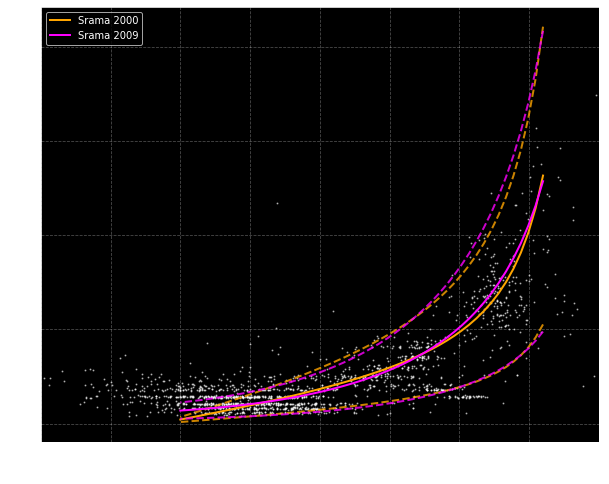

In [6]:
# Compute the velocity values and corresponding errors for both functions
qi_tr_range = np.linspace(8, 60)

vel_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[0] for k in qi_tr_range]
vel_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[0] for k in qi_tr_range]

vel_srama2000 = np.array(vel_srama2000)
vel_srama2009 = np.array(vel_srama2009)

vel_err_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[1] for k in qi_tr_range]
vel_err_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[1] for k in qi_tr_range]

vel_err_srama2000 = np.array(vel_err_srama2000)
vel_err_srama2009 = np.array(vel_err_srama2009)

# Plot the functions and also the calibration data points
plt.figure(figsize=(10, 8))
plt.scatter(iid_qi_cal_df["QI_TR"], iid_qi_cal_df["PSU_VEL"],
            s=1, alpha=0.5, color="w")

# Plot the Srama 2000 function
plt.plot(qi_tr_range, vel_srama2000,
         color="orange", lw=2, label="Srama 2000")
plt.plot(qi_tr_range, vel_srama2000 + vel_err_srama2000,
         color="orange", lw=2, linestyle="dashed", alpha=0.8)
plt.plot(qi_tr_range, vel_srama2000 - vel_err_srama2000,
         color="orange", lw=2, linestyle="dashed", alpha=0.8)

# Plot the Srama 2009 function
plt.plot(qi_tr_range, vel_srama2009,
         color="magenta", lw=2, label="Srama 2009")
plt.plot(qi_tr_range, vel_srama2009 + vel_err_srama2009,
         color="magenta", lw=2, linestyle="dashed", alpha=0.8)
plt.plot(qi_tr_range, vel_srama2009 - vel_err_srama2009,
         color="magenta", lw=2, linestyle="dashed", alpha=0.8)

plt.legend(fancybox=True, loc="upper left")

plt.grid(linestyle="dashed", alpha=.3)

plt.xlim(80, 0)
plt.xlabel("QI rise time in $\mu s$")
plt.ylabel("Velocity in km/s")

## Data Preparation

In [7]:
# It may be help to compute our ML model in LOG10 space
iid_qi_cal_df.loc[:, "PSU_VEL"] = np.log10(iid_qi_cal_df["PSU_VEL"])

In [8]:
# Extract input and output values (and weight)
pre_data = iid_qi_cal_df.to_numpy()

## Machine Learning - Custom Loss Function

Our regression task is simple: the loss function is based on MSE and the training process tries to minimize the loss. However, to make the calibration more comparable to the already existing ones, let's try to "enforce" the output function: the function shall be decreasing w.r.t. a larger rise time. Consequently: a larger rise time will correspond to a slower impact velocity. However, 2 losses: MSE and this custom one, need a proper "balancing"

In [9]:
def decreasing_loss(y_true, y_pred):
    
    # Calculate the difference between consecutive outputs
    diff = y_pred[:, 1:] - y_pred[:, :-1]
    
    # Penalize positive differences
    violation = tf.nn.relu(diff)
    
    # Sum up the violations
    loss = K.sum(violation)
    
    return loss

# A short example
y_pred = np.array([[20.0, 19.0, 15.0, 10.0, 11.0, 5.0, 2.0]])

print(f"y_pred: {y_pred}")
diff = y_pred[:, 1:] - y_pred[:, :-1]
print(f"Consecutive differences: {diff}")
violation = tf.nn.relu(diff)
print(f"Violation term: {violation}")

y_pred: [[20. 19. 15. 10. 11.  5.  2.]]
Consecutive differences: [[-1. -4. -5.  1. -6. -3.]]
Violation term: [[0. 0. 0. 1. 0. 0.]]


2023-06-13 22:13:31.966383: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Machine Learning - Hypermodel

In [10]:
# We define a model that can be used and interpreted by Keras Tuner
def build_model(hp):
    
    # Input shape is 4: rise time and charge for the QT and QI, respectively
    inputs = tf.keras.Input(shape=(1,),
                            name="iid_data",)

    # Each layer will contain some "range" of activation units that will be used by Keras Tuner
    layer = tf.keras.layers.Dense(units=hp.Int("1st_units",
                                               min_value=32,
                                               max_value=128,
                                               step=32),
                                  activation="relu",)(inputs)

    if hp.Boolean("1st_dropout"):
        layer = tf.keras.layers.Dropout(hp.Float("1st_dr_rate",
                                                 min_value=0.1,
                                                 max_value=0.5,
                                                 step=0.1))(layer)

    layer = tf.keras.layers.Dense(units=hp.Int("2nd_units",
                                               min_value=16,
                                               max_value=64,
                                               step=16),
                                  activation="relu",)(layer)

    if hp.Boolean("2nd_dropout"):
        layer = tf.keras.layers.Dropout(hp.Float("2nd_dr_rate",
                                                 min_value=0.1,
                                                 max_value=0.5,
                                                 step=0.1))(layer)
                                  
    # One "branch" for the velocity and one for the log10 mass
    psu_layer = tf.keras.layers.Dense(units=hp.Int("1st_vel_activation",
                                                   min_value=4,
                                                   max_value=16,
                                                   step=4),
                                      activation="relu",)(layer)
    
    # Velocity output layer
    output_psu_layer = tf.keras.layers.Dense(units=1,
                                             name="output_PSU")(psu_layer)


    # Build up the model with the two output branches
    model = tf.keras.Model(inputs=inputs, outputs=output_psu_layer)

    # We add now our custom loss function. Consider the corresponding weights! Try to find the best
    # solution or edit the loss function to e.g., "focus" more on shorter rise times
    model.compile(optimizer="adam",
                  loss=["mean_squared_error", decreasing_loss],
                  loss_weights=[1.0, 1.0],
                  weighted_metrics=[tf.keras.metrics.RootMeanSquaredError(),
                                    "mean_absolute_error"])
    
    return model

In [11]:
# Define a callback function that conducts Early Stopping, based on the validation loss
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=10,
                                               restore_best_weights=True)

# Creat a custom Keras Tuner ... Tuner
class CVTuner(keras_tuner.engine.tuner.Tuner):
    
    # This function runs during "search" and contains a scikit-learn based K-Fold cross validation
    def run_trial(self, trial, data, batch_size=8, epochs=1):
        
        # Define the 5-K-Fold cross validation -> 1/5 are for testing (20 %), rest (80 %) are for 
        # training and validation
        cv = sklearn.model_selection.KFold(5)
        
        # Create a list that stores the resulting validation loses during the 5 fold validation
        # process
        val_losses = []

        # Conduct now a training process (5 times)
        for _ in range(5):
          
            # Create now stratified train / val split
            x_pre_train, x_pre_val = \
                sklearn.model_selection.train_test_split(data,
                                                         test_size=0.1)

            # Enforce a proper order, based on the rise time column
            x_pre_train = x_pre_train[x_pre_train[:, 0].argsort()]
            x_pre_val = x_pre_val[x_pre_val[:, 0].argsort()]
            
            x_train = x_pre_train[:, 0]
            x_train = x_train.reshape(-1, 1)
            
            y_train = x_pre_train[:, 1]
            y_train = y_train.reshape(-1, 1)
            
            x_val = x_pre_val[:, 0]
            x_val = x_val.reshape(-1, 1)
            
            y_val = x_pre_val[:, 1]
            y_val = y_val.reshape(-1, 1)
        
            # Conduct the training. Note: shuffle needs to be set to false, otherwise the order of
            # the input is randomized and our custom function does not work anymore!
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(x_train,
                      y_train,
                      validation_data=[x_val, y_val],
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[es_callback],
                      verbose=0)
            
            # Store the validation loss
            val_losses.append(min(model.history.history['val_loss']))

        # Compute now the mean of all 5 validation losses as the final result
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})

# Build up the Tuner
tuner = CVTuner(hypermodel=build_model,
                oracle=keras_tuner.oracles.BayesianOptimization(
                    objective='val_loss',
                    max_trials=25),
                overwrite=True)

In [12]:
# Yes ... yes ... this is not best practice: we scale all our data and split is afterwards. But:
# we consider the min-max scaler that "squeezes" all data between 0 and 1 (the rise times). The same
# method is also applied on images (data ranging from 0 to 255). Since we will have NO further
# calibration data, let's assume that the upper and lower boundaries are set -> thus the scaler
X_scaler = sklearn.preprocessing.MinMaxScaler()
pre_data[:, 0] = X_scaler.fit_transform(pre_data[:, 0].reshape(-1, 1)).transpose()[0]

In [13]:
# Conduct now a hyper-parameter search
tuner.search(data=pre_data, epochs=100)

Trial 25 Complete [00h 00m 19s]
val_loss: 0.038580283522605896

Best val_loss So Far: 0.03442797958850861
Total elapsed time: 00h 10m 57s
INFO:tensorflow:Oracle triggered exit


## Best ML Model

In [14]:
# Obtain the hyper-parameters of the best model and re-build the model, based on these paramters
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [15]:
model.summary()

Model: "model_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 iid_data (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_378 (Dense)           (None, 64)                128       
                                                                 
 dense_379 (Dense)           (None, 48)                3120      
                                                                 
 dropout_145 (Dropout)       (None, 48)                0         
                                                                 
 dense_380 (Dense)           (None, 16)                784       
                                                                 
 output_PSU (Dense)          (None, 1)                 17        
                                                                 
Total params: 4,049
Trainable params: 4,049
Non-trainable

In [16]:
# Create now stratified train / val split
x_pre_train, x_pre_val = \
    sklearn.model_selection.train_test_split(pre_data,
                                             test_size=0.1)

x_pre_train = x_pre_train[x_pre_train[:, 0].argsort()]
x_pre_val = x_pre_val[x_pre_val[:, 0].argsort()]

x_train = x_pre_train[:, 0]
x_train = x_train.reshape(-1, 1)

y_train = x_pre_train[:, 1]
y_train = y_train.reshape(-1, 1)

x_val = x_pre_val[:, 0]
x_val = x_val.reshape(-1, 1)

y_val = x_pre_val[:, 1]
y_val = y_val.reshape(-1, 1)

In [17]:
# Now we create our final model. But without any cross-validation. This could be a nice task for the
# reader to finalize it using 5-K-Fold cross validation
model.fit(x=x_train,
          y=y_train,
          batch_size=8,
          epochs=300,
          validation_data=[x_val, y_val],
          verbose=0,
          callbacks=[es_callback])

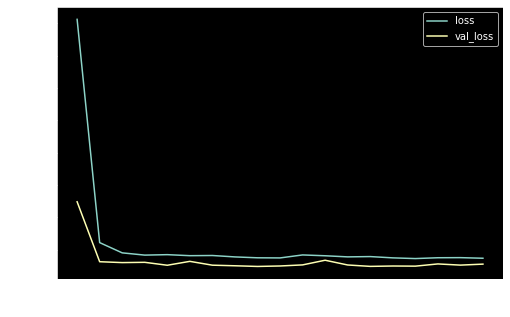

In [18]:
# Plotting the loss function(s)
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'], label="loss")
plt.plot(model.history.history['val_loss'], label="val_loss")
plt.xlabel(r"Epoch")
plt.ylabel(r"Loss")
plt.legend()

## Plotting the final model

In [19]:
# Create a range of rise time and scale it accordingly
tr = np.linspace(5, 80, 100)
tr = tr.reshape(-1, 1)
tr_scaled = X_scaler.transform(tr)

# Predict the corresponding velocities and re-scale them
vel = model.predict(tr_scaled)

Text(0, 0.5, 'Velocity in km/s')

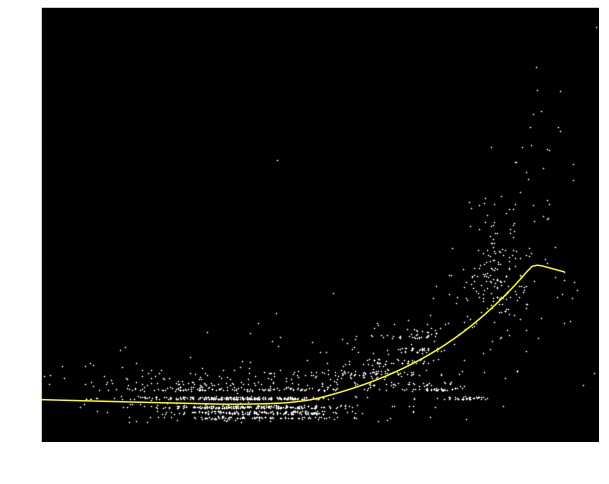

In [20]:
# Below: the calibration data as data points ...
plt.figure(figsize=(10, 8))

# Note: we worked in the log10 domain
plt.scatter(X_scaler.inverse_transform(iid_qi_cal_df["QI_TR"].values.reshape(-1, 1)),
            10.0**iid_qi_cal_df["PSU_VEL"],
            s=1,
            alpha=0.5,
            color="w")

plt.plot(tr, 10.0**vel, "yellow")

plt.xlim(80, 0)
plt.xlabel("QI rise time in $\mu s$")
plt.ylabel("Velocity in km/s")

Text(0, 0.5, 'Velocity in km/s')

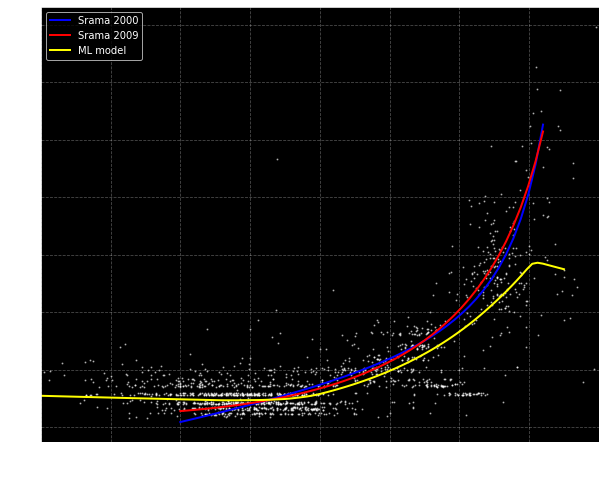

In [21]:
# Compute the velocity values and corresponding errors for both functions
qi_tr_range = np.linspace(8, 60)

vel_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[0] for k in qi_tr_range]
vel_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[0] for k in qi_tr_range]

vel_srama2000 = np.array(vel_srama2000)
vel_srama2009 = np.array(vel_srama2009)

# Plot the functions and also the calibration data points
plt.figure(figsize=(10, 8))
plt.scatter(X_scaler.inverse_transform(iid_qi_cal_df["QI_TR"].values.reshape(-1, 1)),
            10.0**iid_qi_cal_df["PSU_VEL"],
            s=1, alpha=0.5, color="w")

# Plot the Srama 2000 function
plt.plot(qi_tr_range, vel_srama2000,
         color="blue", lw=2, label="Srama 2000")

# Plot the Srama 2009 function
plt.plot(qi_tr_range, vel_srama2009,
         color="red", lw=2, label="Srama 2009")

# The ML model
plt.plot(tr, 10.0**vel,
         color="yellow",
         lw=2, label="ML model")

plt.legend(fancybox=True, loc="upper left")

plt.grid(linestyle="dashed", alpha=.3)

plt.xlim(80, 0)
plt.xlabel("QI rise time in $\mu s$")
plt.ylabel("Velocity in km/s")